<h1>Uber supply demand mismatch analysis</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<p>
    The data consists of cab supply-demand data to and from airport
</p>

In [2]:
df=pd.read_csv('Uber-Request-Data.csv')
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [3]:
# getting an overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


It seems like there are considerable number of missing values in Driver id and Drop time-stamp. It may also be that drop timestamp may be missing for trips that are not completed. 

<h3>Propotion of complete, incomplete and cancelled trips</h3>

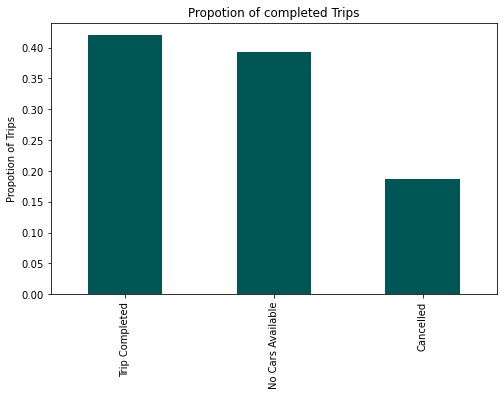

In [49]:
# completed -vs- incomplete trips
df['Status'].value_counts(normalize=True).plot(kind='bar',color='#005555',figsize=(8,5))
plt.title('Propotion of completed Trips')
plt.ylabel('Propotion of Trips');

It seems like number of trips that could not take place due to car unavailability is almost equal to the number of completed trips which represents a huge loss of business opportunity

### Creating Features from request-timestamp and drop-timestamp

In [5]:
# Converting date columns 
df['Request timestamp']=pd.to_datetime(df['Request timestamp'])
df['Drop timestamp']=pd.to_datetime(df['Drop timestamp'])

# Creating features for request_year,request_month and request _date
df['request_year']=df['Request timestamp'].dt.year
df['request_month']=df['Request timestamp'].dt.month
df['request_date']=df['Request timestamp'].dt.day
df['request_hour']=df['Request timestamp'].dt.hour
df['request_min']=df['Request timestamp'].dt.minute

df['Trip_duration']=df['Drop timestamp']-df['Request timestamp']


#### Completed Trips

In [6]:
completed_trips=df[df['Status']=='Trip Completed']
completed_trips.isnull().sum()

Request id           0
Pickup point         0
Driver id            0
Status               0
Request timestamp    0
Drop timestamp       0
request_year         0
request_month        0
request_date         0
request_hour         0
request_min          0
Trip_duration        0
dtype: int64

So for completed_trips information for all feilds are available

In [7]:
# Trips where cars were unavailable
unavailable=df[df['Status']=='No Cars Available']

In [8]:
# Cancelled trips
cancelled=df[df['Status']=='Cancelled']

### Analysis of completed trips

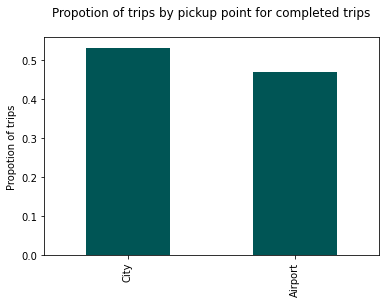

In [9]:
# Seggregation of trips by pickup point

completed_trips['Pickup point'].value_counts(normalize=True).plot(kind='bar',color='#005555')
plt.title('Propotion of trips by pickup point for completed trips\n')
plt.ylabel('Propotion of trips');

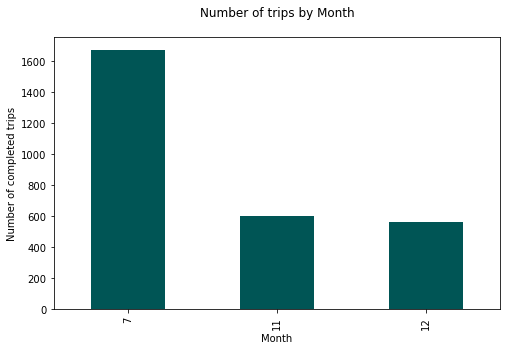

In [10]:
# Trips by month
completed_trips['request_month'].value_counts().plot(kind='bar',color='#005555',figsize=(8,5))
plt.title('Number of trips by Month\n')
plt.xlabel('Month')
plt.ylabel('Number of completed trips');

### Trips vs hour-of-the-day

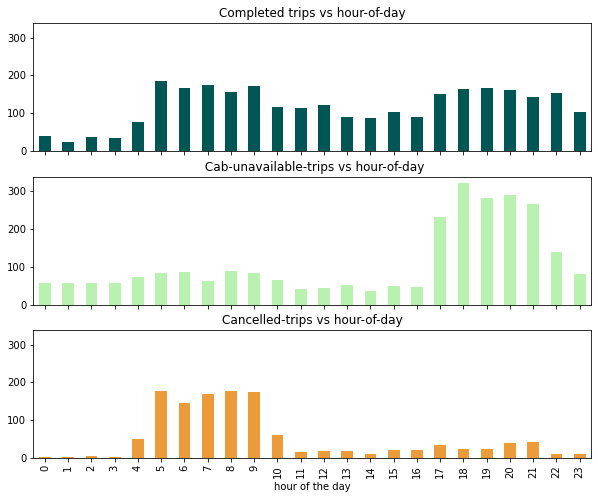

In [11]:
fig,ax=plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True)

completed_trips['request_hour'].value_counts().sort_index().\
plot(kind='bar',color='#005555',figsize=(10,8),label='Completed_trips',ax=ax[0])
ax[0].set_title('Completed trips vs hour-of-day')

unavailable['request_hour'].value_counts().sort_index().\
plot(kind='bar',color='#B8F1B0',label='Cab unavailable',ax=ax[1])
ax[1].set_title('\n Cab-unavailable-trips vs hour-of-day')

cancelled['request_hour'].value_counts().sort_index().\
plot(kind='bar',color='#EC9B3B',label='Cancelled',ax=ax[2])
ax[2].set_title('Cancelled-trips vs hour-of-day')

plt.xlabel('hour of the day');


The above plot indicates 2 distinct patterns. Highest demand occurs in the morning from 5 tp 9 when also majority of cancellations happen and in the evening from 17:00 to 23:00 when the demand for cabs is much higher than supply.

### Identifying the types of most problematic trips for cab unvailable

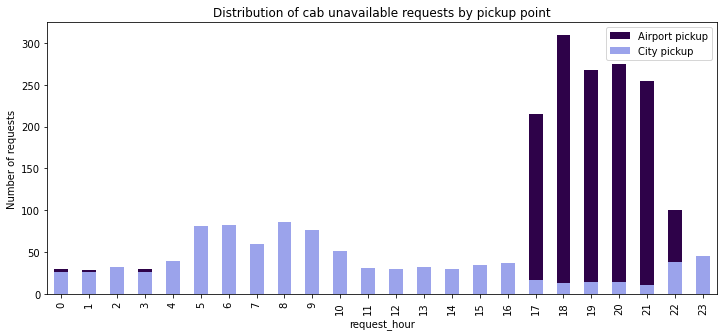

In [12]:
u1=unavailable.pivot_table(index='request_hour',columns='Pickup point',values='Request id',aggfunc='count')

u1['Airport'].plot(figsize=(12,5),label='Airport pickup',color='#2E0249',kind='bar');
u1['City'].plot(label='City pickup',color='#9BA3EB',kind='bar')

plt.title('Distribution of cab unavailable requests by pickup point')
plt.ylabel('Number of requests')
plt.legend();

From the above plot, it is evident that between 17:00 and 22:00, the cab demand from airport to the city is huge but there are not enough cabs at the airport to service this demand. This represents lost business opportunity for the company. Major part of this problem can be addressed by ensuring more cab availability at the airport between 17:00 and 22:00

<h3>Identifying the types of most problematic trips for cancelled trips</h3>

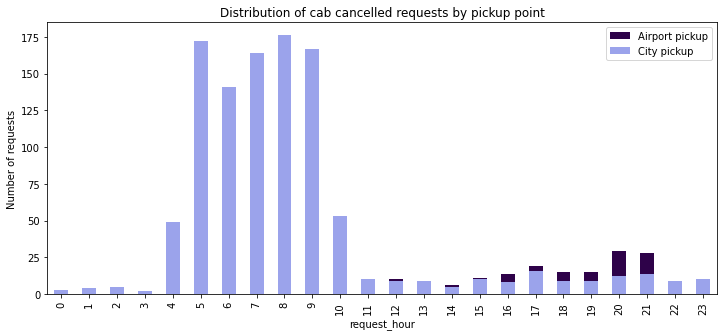

In [13]:
u2=cancelled.pivot_table(index='request_hour',columns='Pickup point',values='Request id',aggfunc='count')
u2.fillna(0,inplace=True)

u2['Airport'].plot(figsize=(12,5),label='Airport pickup',color='#2E0249',kind='bar')
u2['City'].plot(label='City pickup',color='#9BA3EB',kind='bar')

plt.title('Distribution of cab cancelled requests by pickup point')
plt.ylabel('Number of requests')
plt.legend();

It can be seen that most cancellations happen for city pickups in the morning hours from 5:00 to 9:00 where traffic from airport is low. This can probably be addressed by increased fare for city to airport for these hours

<h3>Exploring Trip Duration</h3>

In [41]:
# function to replace extreme values

def replace_extreme_values(arr,pct=90):
    '''function to cap extreme values in an array
    lower bound=100-pct
    upper bound=pct
    pct-- percentile value with which extremely high values are to be capped
    '''
    l_cap=np.percentile(arr,100-pct)
    u_cap=np.percentile(arr,pct)
    
    arr1=np.where(arr<l_cap,l_cap,arr)
    arr1=np.where(arr>u_cap,u_cap,arr)
    
    return arr1

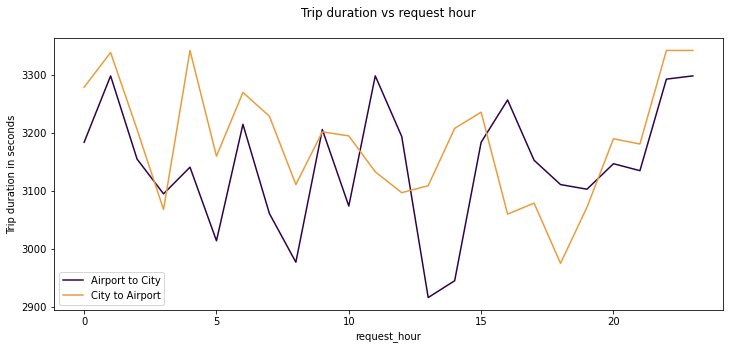

In [48]:
trip_duration=completed_trips.pivot_table(index='request_hour',columns='Pickup point',values='Trip_duration',aggfunc='mean')

trip_duration['A2C']=replace_extreme_values(trip_duration['Airport'].dt.seconds)
trip_duration['C2A']=replace_extreme_values(trip_duration['City'].dt.seconds)

trip_duration['A2C'].plot(color='#2E0249',label='Airport to City',figsize=(12,5))
trip_duration['C2A'].plot(color='#EC9B3B',label='City to Airport')

plt.title('Trip duration vs request hour\n')
plt.ylabel('Trip duration in seconds')

plt.legend();

It can be seen that in the morning hours from 5:00 to 9:00, city to airport trips take significantly longer which may be a factor for high cancellation rates during this time window. On average city to airport trips take more time than the other way around which is understandable given cabs likely face more traffic inside the city

<h3>Possible reasons for supply demand gap</h3>

The main supply demand gap exists for airport to city trips between 17:00 and 22:00. This may be because more flights land during this time window and resulting number of passengers are more than what available cabs can service. Similarly, high cancellation rates can be seen during early morning hours from city to airport since not many flights arrive during this time. Also this coincides with peak office hour traffic resulting in significantly longer trip durations from city to airport

<h3>Possible solutions</h3>

Surge pricing may be introduced for late night airport to city trips to incentivise more cab drivers to be available. Same may be done for the early morning hours to reduce cancellation rates